First, install Rust in the same environment as the transformers library uses tokenizers built in Rust. 
* paste the following line in a new terminal and hit enter: 
 ```curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh```

* Then install transformers and datasets


In [1]:
#!pip install transformers datasets
PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0

In [2]:
import torch
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
import time

In [3]:
trec_data = load_dataset('trec', split='train[:1000]')
trec_data

Found cached dataset trec (/Users/dipakrimal/.cache/huggingface/datasets/trec/default/2.0.0/f2469cab1b5fceec7249fda55360dfdbd92a7a5b545e91ea0f78ad108ffac1c2)


Dataset({
    features: ['text', 'coarse_label', 'fine_label'],
    num_rows: 1000
})

In [4]:
trec_data[0]

{'text': 'How did serfdom develop in and then leave Russia ?',
 'coarse_label': 2,
 'fine_label': 26}

In [5]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
# take the first 64 rows of the trec data
text = trec_data['text'][:64]
# tokenize text using the BERT tokenizer
tokens = tokenizer(
    text, max_length=128,
    truncation=True, padding=True,
    return_tensors='pt'
)


In [7]:
%%timeit
model(**tokens)

536 ms ± 23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
device = 'mps'
model.to(device)
tokens.to(device)
device

'mps'

In [9]:
%%timeit
model(**tokens)


236 ms ± 35.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
from time import time

def run_tests(on_device='cpu'):
    reruns = 10
    b = 8
    times = []
    device = torch.device(on_device)
    model.to(device)
    for i in range(2, b):
        text = trec_data['text'][:2**i]
        tokens = tokenizer(
            text, max_length=512,
            truncation=True, padding=True,
            return_tensors='pt'
        )
        if on_device == 'mps':
            tokens.to(device)
        tot_time = 0
        for _ in range(reruns):
            t0 = time()
            model(**tokens)
        tot_time += time()-t0
        times.append(tot_time/reruns)
    return times

In [11]:
# Run on CPU 
cpu_times = run_tests()

In [12]:
# Run on GPU 
mps_times = run_tests(on_device='mps')

In [13]:
import matplotlib.pyplot as plt

In [14]:
batch_sizes = [2**i for i in range(2, 8)]

In [15]:
cpu_times

[0.005241990089416504,
 0.007774901390075683,
 0.012727689743041993,
 0.023450207710266114,
 0.05256609916687012,
 0.12736740112304687]

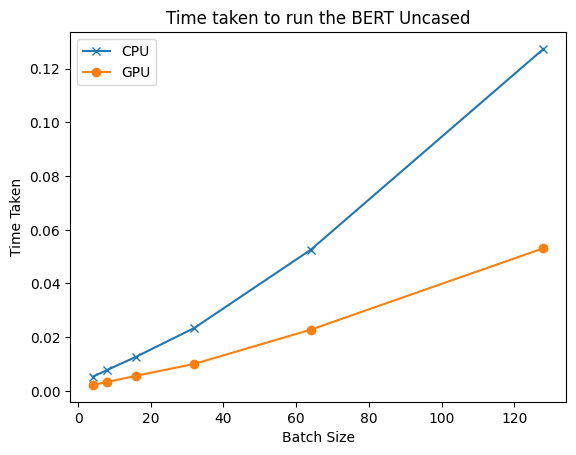

In [20]:
plt.plot(batch_sizes, cpu_times, 'x-', label='CPU')
plt.plot(batch_sizes, mps_times, 'o-', label='GPU')
plt.xlabel("Batch Size")
plt.ylabel("Time Taken")
plt.title("Time taken to run the BERT Uncased")
plt.legend(loc='best')
plt.show()

The acceleration looks signficant but my 8 GB M1 mac quickly out of memory and could not test even larger chunks.  